# Diamond price model development project

**Project objectives:**

1. develop a model that will predict the price of a diamond based on a set of characteristics
2. deploy the trained model with tensorflow serving
3. develop a simple web interface using streamlit to make online predictions of a diamond price
4. develop pipeline that will automatically train a model and deploy it in production 

### Intoduction

This project uses a dataset of 

This notebook goes through diamond price prediction model development. The model is developed in tensorflow 2. 

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 

print(tf.__version__)

2.8.0


In [5]:
import tensorflow_datasets as tfds
print(tfds.__version__)

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [3]:
print(tf.keras.__version__)

2.8.0


In [159]:
##we will be loading data from the file

#1. load the dataset into 

df = pd.read_csv('diamonds.csv')

print(len(df))
df.head()


53940


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [5]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [160]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [6]:
##split the dataframe to train and test
y = df.pop('price')
X = df

df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(X,y, test_size=0.20,random_state=42)

display(X.head())
display(y.head())

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


0    326
1    326
2    327
3    334
4    335
Name: price, dtype: int64

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   x        53940 non-null  float64
 7   y        53940 non-null  float64
 8   z        53940 non-null  float64
dtypes: float64(6), object(3)
memory usage: 3.7+ MB


In [7]:
print('the size of the training set: x:{}, y:{}'.format(len(df_train_X), len(df_train_y)))
print('the size o the validation set: x:{}, y:{}'.format(len(df_test_X), len(df_test_y)))

the size of the training set: x:43152, y:43152
the size o the validation set: x:10788, y:10788


Plan of action:

    1. convert dataframe to dataset - use dict() to wrap a pandas dataframe with different tpes 
         
    2. remap the dataset to set a label - this has been replaced with 1. splitting data to features and label df, and passing it to from_tensor_slices function
    3. data preprocessing
        - convert categorical  variables 
        - normalize numeric features
        
    4. build a model 

In [8]:
tf.data.Dataset.from_tensor_slices(dict(df_train_X[['x','cut']]))

<TensorSliceDataset element_spec={'x': TensorSpec(shape=(), dtype=tf.float64, name=None), 'cut': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [9]:
##create a dataset from a dataframe  - this is so you can do preprocessing directly in a model

##using tf.data.Datasets.from_tensor_slices()

train_ds = tf.data.Dataset.from_tensor_slices((dict(df_train_X),df_train_y))
test_ds = tf.data.Dataset.from_tensor_slices((dict(df_test_X), df_test_y))


In [10]:
##you need to patch the datasest here


train_ds = train_ds.batch(64)
test_ds = test_ds.batch(64)

In [34]:
train_ds.take(1)

<TakeDataset element_spec=({'carat': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'cut': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'color': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'clarity': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'depth': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'table': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'x': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'y': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'z': TensorSpec(shape=(None,), dtype=tf.float64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [11]:
##code to produce names and types of the columns 

columns = list(df_train_X.columns)

for column in columns:
    print('name:', column)
    print('type: ',df_train_X[column].dtype)

name: carat
type:  float64
name: cut
type:  object
name: color
type:  object
name: clarity
type:  object
name: depth
type:  float64
name: table
type:  float64
name: x
type:  float64
name: y
type:  float64
name: z
type:  float64


In [16]:
##can we create input layer and infer the info (name, type) from the pandas dataframe? 

df_train_X['carat'].dtypes

dtype('float64')

In [12]:
##create a list of feature names, separate them by type

NUMERIC_FEATURES = ['carat','depth','table','x','y','z']
CATEGORICAL_FEATURES = ['cut','color','clarity']

In [234]:
##create inputs 
    ## it is a dictionary if inputs - from numeric and categorical ones 

##all_inputs = {column: tf.keras.Input(shape=(1,),name=column, dtype=tf.float64) for column in NUMERIC_FEATURES}
##all_inputs.update({column: tf.keras.Input(shape=(1,),name=column, dtype=tf.string) for column in CATEGORICAL_FEATURES})

##using for loop to create inputs


In [228]:
all_inputs

{'carat': <tf.Tensor 'carat_9:0' shape=(None, 1) dtype=float64>,
 'depth': <tf.Tensor 'depth_9:0' shape=(None, 1) dtype=float64>,
 'table': <tf.Tensor 'table_9:0' shape=(None, 1) dtype=float64>,
 'x': <tf.Tensor 'x_9:0' shape=(None, 1) dtype=float64>,
 'y': <tf.Tensor 'y_9:0' shape=(None, 1) dtype=float64>,
 'z': <tf.Tensor 'z_9:0' shape=(None, 1) dtype=float64>,
 'cut': <tf.Tensor 'cut_6:0' shape=(None, 1) dtype=string>,
 'color': <tf.Tensor 'color_6:0' shape=(None, 1) dtype=string>,
 'clarity': <tf.Tensor 'clarity_6:0' shape=(None, 1) dtype=string>}

In [235]:
for feature in all_inputs.items():
    print('feature name: ', feature)

feature name:  ('carat', <tf.Tensor 'carat_12:0' shape=(None, 1) dtype=float64>)
feature name:  ('depth', <tf.Tensor 'depth_12:0' shape=(None, 1) dtype=float64>)
feature name:  ('table', <tf.Tensor 'table_12:0' shape=(None, 1) dtype=float64>)
feature name:  ('x', <tf.Tensor 'x_12:0' shape=(None, 1) dtype=float64>)
feature name:  ('y', <tf.Tensor 'y_12:0' shape=(None, 1) dtype=float64>)
feature name:  ('z', <tf.Tensor 'z_12:0' shape=(None, 1) dtype=float64>)
feature name:  ('cut', <tf.Tensor 'cut_7:0' shape=(None, 1) dtype=string>)
feature name:  ('color', <tf.Tensor 'color_7:0' shape=(None, 1) dtype=string>)
feature name:  ('clarity', <tf.Tensor 'clarity_7:0' shape=(None, 1) dtype=string>)


In [309]:
norm_cat = tf.keras.layers.experimental.preprocessing.StringLookup()
norm_cat.adapt(train_ds.map(lambda x,y: x['cut']))
print(len(norm_cat.get_vocabulary()))
norm_cat(df_train_X['cut'])


7


<tf.Tensor: shape=(43152,), dtype=int64, numpy=array([5, 4, 3, ..., 4, 3, 3], dtype=int64)>

In [82]:
##preprocessing functions

##for numerical features

def get_preprocessing_layer(dataset, feature):
    
    ##prepare dataset with one feature only
    ds_feature = dataset.map(lambda x,y: x[feature])
    ##ds_feature = ds_feature.map(lambda x: tf.expand_dims(x,-1))
    
    #print("feature sample for:", feature)
    #print(ds_feature.take(1))
    
    if feature in NUMERIC_FEATURES:
        print("the feature {} is of type numeric".format(feature))
        
        normalizer = tf.keras.layers.Normalization(axis=None)
        
    elif feature in CATEGORICAL_FEATURES: 
        print("the feature {} is of type categorical".format(feature))

        normalizer = tf.keras.layers.StringLookup(output_mode='multi_hot')
    
    ##fit a normalizer to the training set
    normalizer.adapt(ds_feature)
    
    ##if feature in CATEGORICAL_FEATURES:
      ##  encoder = tf.keras.layers.CategoryEncoding(num_tokens=normalizer.vocabulary_size())
        ##encoder.adapt(normalizer(ds_feature).numpy())
        
        #encoder.adapt(normalizer(df_train_X[feature]))
        #print("encoder")
       ## print(encoder)
        ##return encoder
     ##   return lambda feature: encoder(normalizer(feature))
    
    ##print(normalizer)
    return normalizer
    

In [181]:
##testing the preprocessing function

layer = get_preprocessing_layer(train_ds, 'cut')
layer(df_train_X['cut'])



<tf.Tensor: shape=(43152,), dtype=int64, numpy=array([5, 4, 3, ..., 4, 3, 3], dtype=int64)>

In [100]:
##create preprocessing layer
    ##format: 

#preprocessed_features = [get_preprocessing_layer(train_ds, feature, input_) for feature, input_ in all_inputs.items()]
##preprocessed_features.append([get_preprocessing_layer(train_ds, feature) for feature in CATEGORICAL_FEATURES])

##doing it through a for loop rather than list comprehension

all_inputs = {}
preprocessed_features = []


for feature_name in NUMERIC_FEATURES+CATEGORICAL_FEATURES:
        
        if feature_name in NUMERIC_FEATURES:
            #create input
            feature_input = tf.keras.Input(shape=(1,),name=feature_name)
            print('feature_input: ', feature_input)
            
        elif feature_name in CATEGORICAL_FEATURES:
            feature_input = tf.keras.Input(shape=(1,),name=feature_name,dtype=tf.string)
            print('feature_input: ', feature_input)
        
        all_inputs[feature_name] = feature_input
        #create transformed feature
        preprocessing_layer = get_preprocessing_layer(train_ds,feature_name)
        #save it in the list
        with_input = preprocessing_layer(feature_input)
        preprocessed_features.append(with_input)
        

#see what you created
print(all_inputs)
print(preprocessed_features)


feature_input:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='carat'), name='carat', description="created by layer 'carat'")
the feature carat is of type numeric
feature_input:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='depth'), name='depth', description="created by layer 'depth'")
the feature depth is of type numeric
feature_input:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='table'), name='table', description="created by layer 'table'")
the feature table is of type numeric
feature_input:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='x'), name='x', description="created by layer 'x'")
the feature x is of type numeric
feature_input:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='y'), name='y', description="created by layer 'y'")
the feature y is of type numeric
feature_input:  KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32

In [101]:
##testing the preprocessing layer only!!

##create a model that does preprocessing only!!
preprocessing = tf.keras.Model(all_inputs, preprocessed_features)

In [52]:
preprocessing.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 carat (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 depth (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 table (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 x (InputLayer)                 [(None, 1)]          0           []                               
                                                                                            

In [77]:
##examine dataset before you pass it to preprocessing model

for something, second in train_ds.take(1).unbatch():
    print('one something:')
    print(something)
    print("second")
    print(second)

one something:
{'carat': <tf.Tensor: shape=(), dtype=float64, numpy=2.01>, 'cut': <tf.Tensor: shape=(), dtype=string, numpy=b'Good'>, 'color': <tf.Tensor: shape=(), dtype=string, numpy=b'F'>, 'clarity': <tf.Tensor: shape=(), dtype=string, numpy=b'SI2'>, 'depth': <tf.Tensor: shape=(), dtype=float64, numpy=58.1>, 'table': <tf.Tensor: shape=(), dtype=float64, numpy=64.0>, 'x': <tf.Tensor: shape=(), dtype=float64, numpy=8.23>, 'y': <tf.Tensor: shape=(), dtype=float64, numpy=8.19>, 'z': <tf.Tensor: shape=(), dtype=float64, numpy=4.77>}
second
tf.Tensor(16231, shape=(), dtype=int64)
one something:
{'carat': <tf.Tensor: shape=(), dtype=float64, numpy=1.01>, 'cut': <tf.Tensor: shape=(), dtype=string, numpy=b'Very Good'>, 'color': <tf.Tensor: shape=(), dtype=string, numpy=b'E'>, 'clarity': <tf.Tensor: shape=(), dtype=string, numpy=b'SI2'>, 'depth': <tf.Tensor: shape=(), dtype=float64, numpy=60.0>, 'table': <tf.Tensor: shape=(), dtype=float64, numpy=60.0>, 'x': <tf.Tensor: shape=(), dtype=float6

In [103]:
## run the preprocessing model from previous cell to see if it does the preprocessing

for features, label in train_ds:

    test222 = preprocessing(features)
    
    ##the result is list of preprocessed features 
    ##each feature in its own array 
    for item in test222:
        print("printing summary")
        print(item.numpy().std())
        
    
    

printing summary
0.99516785
printing summary
0.9291668
printing summary
1.1465484
printing summary
1.005131
printing summary
0.96856534
printing summary
0.9711448
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.3142697
printing summary
0.98268765
printing summary
0.97532004
printing summary
0.93321526
printing summary
1.0046796
printing summary
0.97305876
printing summary
0.9516542
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.7886283
printing summary
0.84696835
printing summary
0.9620139
printing summary
0.8335701
printing summary
0.8093816
printing summary
0.83346343
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.9192294
printing summary
0.87556285
printing summary
0.976456
printing summary
0.9692747
printing summary
0.93447864
printing summary
0.93034637
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing sum

0.93300825
printing summary
0.9254274
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.3142697
printing summary
1.0705518
printing summary
0.81871504
printing summary
0.98883116
printing summary
1.0350894
printing summary
1.001622
printing summary
1.0038788
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.3142697
printing summary
0.8104946
printing summary
0.7522876
printing summary
1.0883274
printing summary
0.88748217
printing summary
0.86476344
printing summary
0.87007403
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.95494634
printing summary
0.8376071
printing summary
1.2157419
printing summary
0.97583866
printing summary
0.9525907
printing summary
0.9318234
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.7839844
printing summary
1.0382429
printing summary
0.87569356
printing summary
0.82113063
printing summary
0.80802125
pr

0.9322707
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.3142697
printing summary
1.1022453
printing summary
1.1158104
printing summary
0.89201236
printing summary
1.0815332
printing summary
1.0479538
printing summary
1.054595
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
1.1114602
printing summary
1.1303804
printing summary
2.2966962
printing summary
1.0767618
printing summary
1.0348767
printing summary
1.2347518
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.9490866
printing summary
0.83331287
printing summary
0.9236052
printing summary
0.9776419
printing summary
0.9408425
printing summary
0.97235173
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.7534706
printing summary
1.2091955
printing summary
1.1913538
printing summary
0.8824481
printing summary
0.85171497
printing summary
0.8334762
printing

printing summary
0.8915321
printing summary
0.7613212
printing summary
1.1186004
printing summary
0.94165605
printing summary
0.91804653
printing summary
0.9806085
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
1.154924
printing summary
1.2649772
printing summary
1.092784
printing summary
1.0941316
printing summary
1.0658728
printing summary
1.0854963
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
1.0028827
printing summary
0.80942905
printing summary
0.7845286
printing summary
1.0247849
printing summary
0.98940146
printing summary
1.0025333
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.99961144
printing summary
1.1617186
printing summary
0.96221
printing summary
0.98100334
printing summary
0.9513724
printing summary
0.9540338
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0

0.9172281
printing summary
0.7628923
printing summary
0.90691924
printing summary
0.9490858
printing summary
0.9323147
printing summary
0.9335999
printing summary
0.372678
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.9527001
printing summary
1.2569875
printing summary
0.9558107
printing summary
0.99045396
printing summary
0.9535764
printing summary
0.9654738
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.3142697
printing summary
0.9471562
printing summary
1.1186337
printing summary
0.97640765
printing summary
0.9456012
printing summary
0.9230563
printing summary
0.90496045
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.94631654
printing summary
1.0774165
printing summary
1.0980257
printing summary
0.97068447
printing summary
0.9323772
printing summary
0.9591028
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.3142697
printing summary
1.0601354
printing

0.31426966
printing summary
0.8297129
printing summary
0.9564253
printing summary
1.0207604
printing summary
0.888942
printing summary
0.8597388
printing summary
0.8579758
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.9113855
printing summary
1.0187842
printing summary
0.9361918
printing summary
0.91363925
printing summary
0.88377255
printing summary
0.91344464
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.3142697
printing summary
0.9000545
printing summary
1.0007553
printing summary
0.9941544
printing summary
0.93244857
printing summary
0.89904326
printing summary
0.9123784
printing summary
0.372678
printing summary
0.3307189
printing summary
0.3142697
printing summary
0.8658083
printing summary
1.0941559
printing summary
0.96413183
printing summary
0.86852765
printing summary
0.83815396
printing summary
0.83949393
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
print

printing summary
1.0412581
printing summary
0.9143358
printing summary
0.93961525
printing summary
1.0443176
printing summary
1.0116862
printing summary
1.0096495
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.3142697
printing summary
0.960693
printing summary
0.86588514
printing summary
1.0178127
printing summary
1.0001489
printing summary
0.9706436
printing summary
0.9646474
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
1.0212669
printing summary
0.9750518
printing summary
0.90921843
printing summary
0.99895775
printing summary
0.9642494
printing summary
0.9702733
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.8787664
printing summary
1.1127255
printing summary
1.0537698
printing summary
0.9037057
printing summary
0.87342405
printing summary
0.89788
printing summary
0.372678
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.91

1.0462103
printing summary
1.047272
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
1.0149659
printing summary
1.0993242
printing summary
0.95049727
printing summary
1.0122299
printing summary
0.98829854
printing summary
1.0095294
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.3142697
printing summary
0.9711817
printing summary
0.98115534
printing summary
0.9113889
printing summary
0.99906033
printing summary
0.95845675
printing summary
0.9532643
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.3142697
printing summary
0.9466186
printing summary
1.2391483
printing summary
1.0601578
printing summary
0.93985695
printing summary
0.89893335
printing summary
0.86408395
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.3142697
printing summary
1.0215414
printing summary
0.8541709
printing summary
0.9012999
printing summary
0.99384266
printing summary
0.9682003
print

printing summary
0.98964614
printing summary
0.78084767
printing summary
0.8509158
printing summary
0.99137104
printing summary
0.9569836
printing summary
1.0164979
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.3142697
printing summary
1.0954671
printing summary
0.99877566
printing summary
0.93226725
printing summary
1.0848682
printing summary
1.0533009
printing summary
1.0797877
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
1.0774137
printing summary
0.7306445
printing summary
0.8798566
printing summary
1.0389276
printing summary
1.0063016
printing summary
1.0062917
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
1.0679642
printing summary
0.80787563
printing summary
0.8685919
printing summary
1.0184331
printing summary
0.9953636
printing summary
0.98453593
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summa

0.3142697
printing summary
1.11184
printing summary
1.1490685
printing summary
1.1060576
printing summary
1.0451891
printing summary
1.0130097
printing summary
1.021787
printing summary
0.372678
printing summary
0.3307189
printing summary
0.3142697
printing summary
0.8508941
printing summary
1.0508292
printing summary
0.8563242
printing summary
0.8856502
printing summary
0.8517875
printing summary
0.83610874
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.3142697
printing summary
0.96427166
printing summary
1.0398694
printing summary
1.0838919
printing summary
0.96017444
printing summary
0.9279414
printing summary
0.9445042
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.9384211
printing summary
1.1011034
printing summary
1.0456305
printing summary
0.96980745
printing summary
0.9323998
printing summary
0.9301232
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summ

0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.9291937
printing summary
0.98587734
printing summary
1.1044576
printing summary
0.9786075
printing summary
0.93814284
printing summary
0.9261358
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.885607
printing summary
1.1537528
printing summary
1.1613325
printing summary
0.91172916
printing summary
0.8786839
printing summary
0.8956091
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.9307481
printing summary
1.1097616
printing summary
0.86326396
printing summary
0.980163
printing summary
0.9527389
printing summary
0.9337935
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.94678617
printing summary
0.9995809
printing summary
1.1326487
printing summary
0.9739431
printing summary
0.9369542
printing summary
0.95054173
printing summary
0.372678
printin

printing summary
0.9429767
printing summary
0.8542457
printing summary
0.9780492
printing summary
0.98234636
printing summary
0.95632756
printing summary
0.96532243
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.82398164
printing summary
0.97152567
printing summary
0.9105951
printing summary
0.8760836
printing summary
0.85149515
printing summary
0.87051696
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
1.0304608
printing summary
0.99890715
printing summary
0.7746379
printing summary
0.96905094
printing summary
0.94101834
printing summary
0.9595865
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.91481775
printing summary
1.0310414
printing summary
0.94825464
printing summary
0.93897974
printing summary
0.911673
printing summary
0.89042497
printing summary
0.372678
printing summary
0.3307189
printing summary
0.31426966
printing 

printing summary
1.0157964
printing summary
0.9828039
printing summary
0.90119267
printing summary
1.0433015
printing summary
1.0170568
printing summary
1.0387658
printing summary
0.372678
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.8198239
printing summary
1.0325817
printing summary
0.9415226
printing summary
0.89370435
printing summary
0.86675364
printing summary
0.87171835
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary
0.6728877
printing summary
0.9712003
printing summary
0.9707816
printing summary
0.7798606
printing summary
0.7529056
printing summary
0.7668397
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.3142697
printing summary
0.9939229
printing summary
0.79574287
printing summary
0.90148705
printing summary
1.0215745
printing summary
0.9900582
printing summary
0.9930479
printing summary
0.37267798
printing summary
0.3307189
printing summary
0.31426966
printing summary


In [112]:
##validate preprocessing in train dataset

test = preprocessing(dict(df_train_X))

for name in test:
    print (name.numpy().std().astype('int32'))

1
1
1
1
1
1
0
0
0


In [152]:
##create a simple model
preprocessed_layers = tf.keras.layers.concatenate(preprocessed_features)
x = tf.keras.layers.Dense(20, activation='relu')(preprocessed_layers)
x = tf.keras.layers.Dense(10, activation='relu')(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [48]:
##debugging cell

preprocessed_layers

<KerasTensor: shape=(None, 29) dtype=float32 (created by layer 'concatenate_4')>

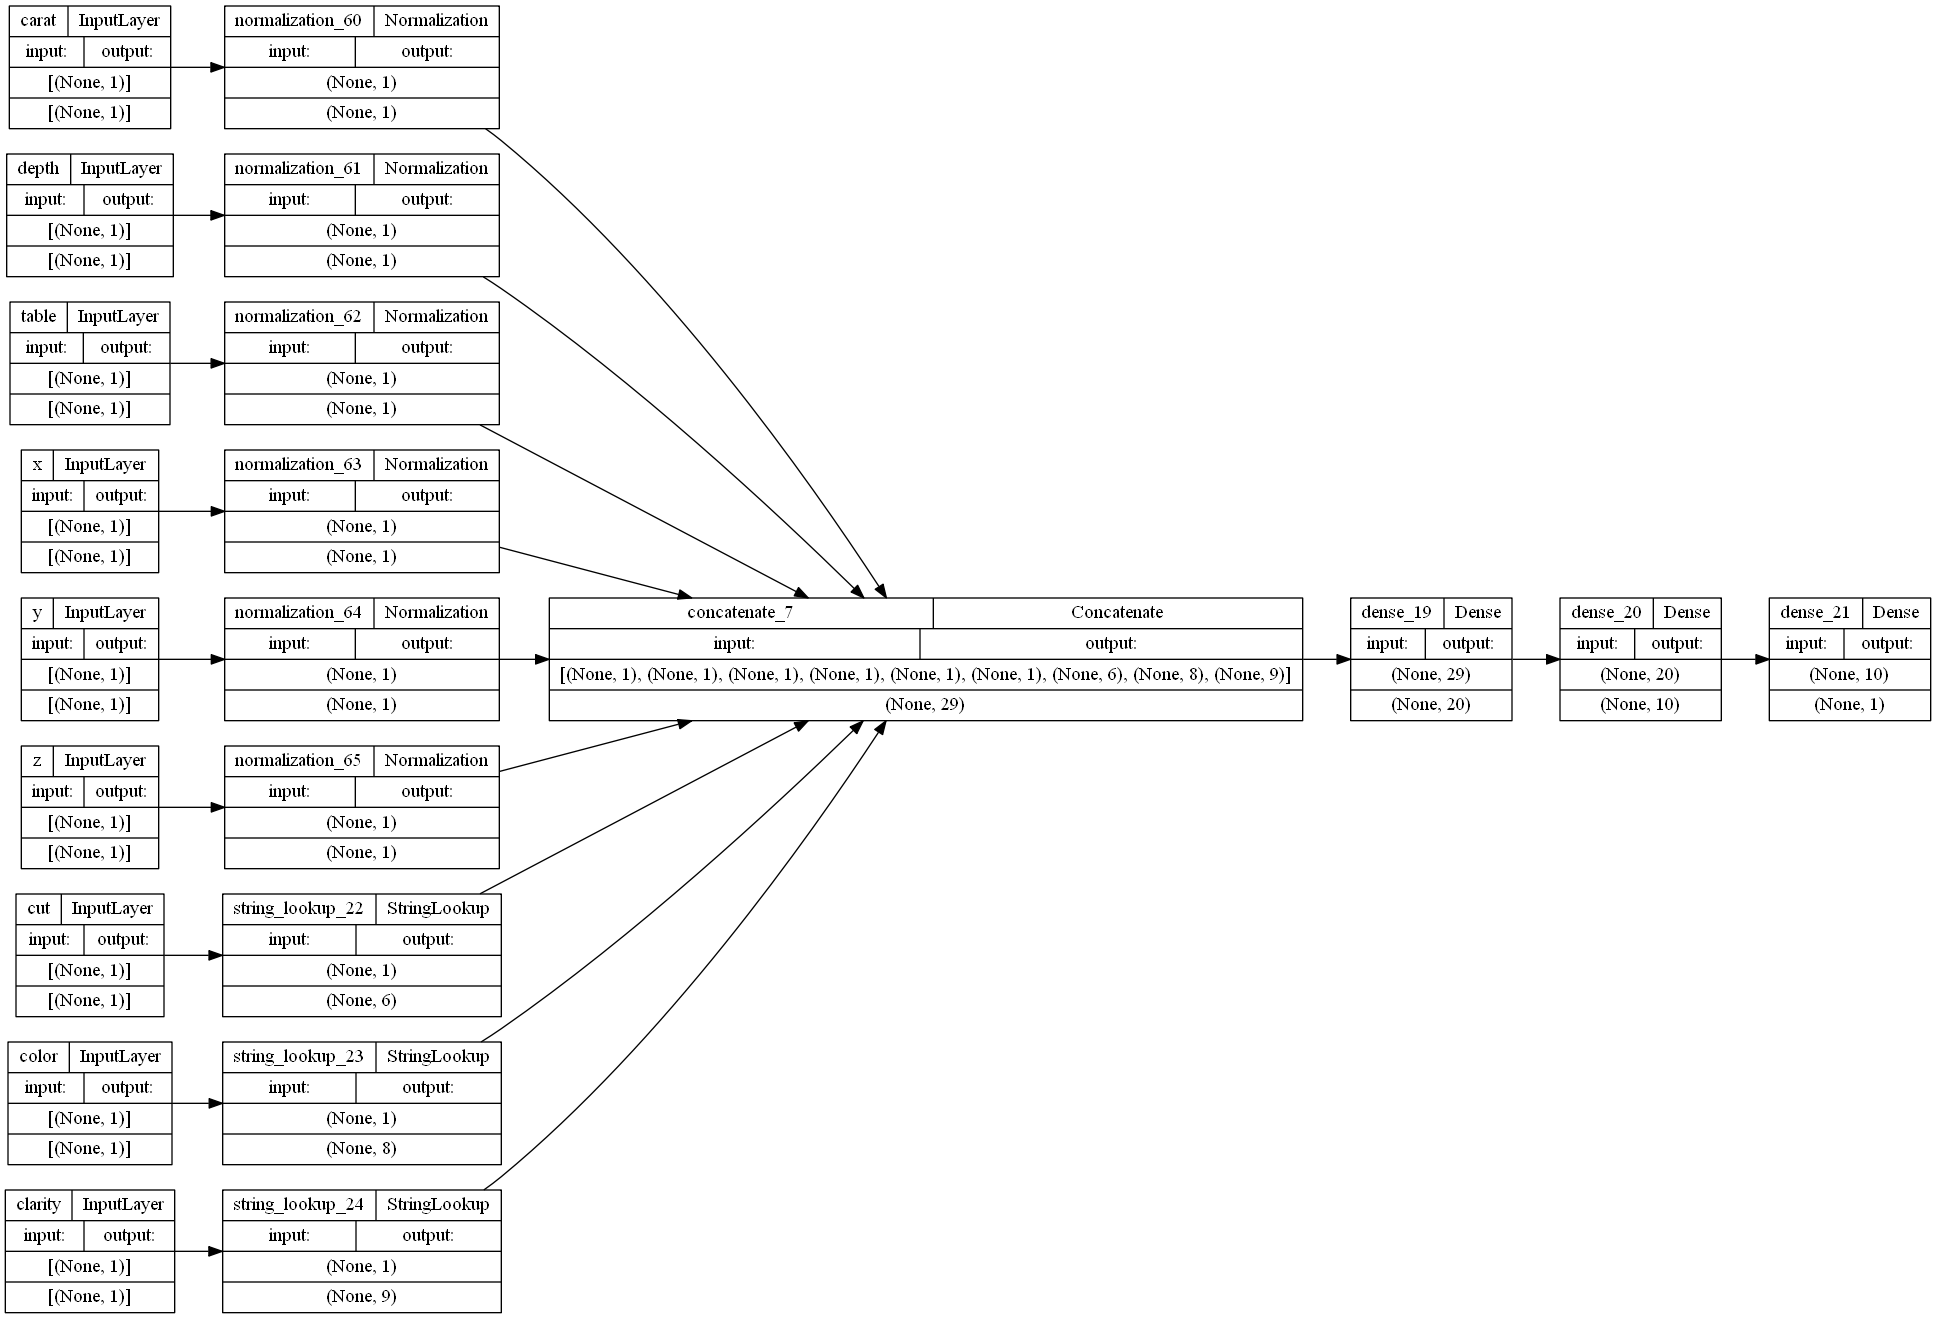

In [153]:
tf.keras.utils.plot_model(model, show_shapes=True,rankdir="LR")

In [87]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 carat (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 depth (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 table (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 x (InputLayer)                 [(None, 1)]          0           []                               
                                                                                            

In [154]:
##compile the model


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
             loss='mean_squared_error',
             metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [116]:
model.layers

In [125]:
import os

TEST = 'DIR'

print(TEST)

DIR


In [155]:
##fit the model

LOGS = 'tb-logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard()

history = model.fit(train_ds, epochs=10, validation_data=test_ds,
         callbacks=[tensorboard_callback])

Epoch 1/10
675/675 [==============================] - 2s 2ms/step - loss: 5772300.0000 - root_mean_squared_error: 2402.5610 - val_loss: 919067.8125 - val_root_mean_squared_error: 958.6802
Epoch 2/10
675/675 [==============================] - 1s 2ms/step - loss: 956809.8125 - root_mean_squared_error: 978.1666 - val_loss: 660571.6875 - val_root_mean_squared_error: 812.7556
Epoch 3/10
675/675 [==============================] - 1s 2ms/step - loss: 762522.6250 - root_mean_squared_error: 873.2254 - val_loss: 565979.5000 - val_root_mean_squared_error: 752.3161
Epoch 4/10
675/675 [==============================] - 1s 2ms/step - loss: 659700.4375 - root_mean_squared_error: 812.2194 - val_loss: 521408.5000 - val_root_mean_squared_error: 722.0862
Epoch 5/10
675/675 [==============================] - 1s 2ms/step - loss: 593633.9375 - root_mean_squared_error: 770.4764 - val_loss: 492086.5312 - val_root_mean_squared_error: 701.4888
Epoch 6/10
675/675 [==============================] - 1s 2ms/step - 

In [157]:
%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 11172), started 0:10:56 ago. (Use '!kill 11172' to kill it.)

In [151]:
!tensorboard dev upload --logdir 'C:/Users/Milan Jendrisek/projects/diamonds/logs'

2022-02-24 16:42:51.837683: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2022-02-24 16:42:51.837714: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
TensorFlow installation not found - running with reduced feature set.
usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: unrecognized arguments: Jendrisek/projects/diamonds/logs'


In [162]:
history.history

{'loss': [5772300.0,
  956809.8125,
  762522.625,
  659700.4375,
  593633.9375,
  547878.0625,
  516864.4375,
  493523.0,
  476303.46875,
  463990.125],
 'root_mean_squared_error': [2402.56103515625,
  978.1665649414062,
  873.2254028320312,
  812.2194213867188,
  770.4764404296875,
  740.1878662109375,
  718.932861328125,
  702.5119018554688,
  690.1473999023438,
  681.168212890625],
 'val_loss': [919067.8125,
  660571.6875,
  565979.5,
  521408.5,
  492086.53125,
  473665.4375,
  459666.84375,
  448972.40625,
  440075.53125,
  432922.25],
 'val_root_mean_squared_error': [958.6802368164062,
  812.755615234375,
  752.3161010742188,
  722.0862426757812,
  701.48876953125,
  688.2335815429688,
  677.9873657226562,
  670.0540161132812,
  663.3818969726562,
  657.96826171875]}

In [176]:
dict(df.loc[9])

{'carat': 0.23,
 'cut': 'Very Good',
 'color': 'H',
 'clarity': 'VS1',
 'depth': 59.4,
 'table': 61.0,
 'price': 338,
 'x': 4.0,
 'y': 4.05,
 'z': 2.39}

In [186]:
df['cut'].unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

In [332]:
##RANDOM TESTING
##unpacking a list

x,y = ['x','y']

print(x)
print(y)

x
y


In [355]:
##make predictions

##create a sample
sample = [{'carat': [0.6],
 'cut': ['Ideal'],
 'color': ['H'],
 'clarity': ['VS1'],
 'depth': [59.4],
 'table': [61.0],
 'x': [4.0],
 'y': [4.05],
 'z': [2.39]}]

samples = [{'carat': [0.6],
 'cut': ['Ideal'],
 'color': ['H'],
 'clarity': ['VS1'],
 'depth': [59.4],
 'table': [61.0],
 'x': [4.0],
 'y': [4.05],
 'z': [2.39]},
 {'carat': [0.6],
 'cut': ['Ideal'],
 'color': ['H'],
 'clarity': ['VS1'],
 'depth': [59.4],
 'table': [61.0],
 'x': [4.0],
 'y': [4.05],
 'z': [2.39]} ]

sample_list = [[0.6],
 ['Ideal'],
 ['H'],
 ['VS1'],
 [59.4],
 [61.0],
 [4.0],
 [4.05],
 [2.39]]

##pass it to a model

print(np.array(sample_list))

##dictionary

##list of dictionaries

##input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}

#1. unpack the list
#2. unpack the dictionary

model_test = [{name: tf.convert_to_tensor([value]) for name, value in example.items()} for example in sample]

print(model_test)

##input_dict = {name: tf.convert_to_tensor([item.value])for item.items() in items for items in sample}

##model.predict_on_batch(model_test)

model(model_test)


[['0.6']
 ['Ideal']
 ['H']
 ['VS1']
 ['59.4']
 ['61.0']
 ['4.0']
 ['4.05']
 ['2.39']]
[{'carat': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.6]], dtype=float32)>, 'cut': <tf.Tensor: shape=(1, 1), dtype=string, numpy=array([[b'Ideal']], dtype=object)>, 'color': <tf.Tensor: shape=(1, 1), dtype=string, numpy=array([[b'H']], dtype=object)>, 'clarity': <tf.Tensor: shape=(1, 1), dtype=string, numpy=array([[b'VS1']], dtype=object)>, 'depth': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[59.4]], dtype=float32)>, 'table': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[61.]], dtype=float32)>, 'x': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.]], dtype=float32)>, 'y': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.05]], dtype=float32)>, 'z': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[2.39]], dtype=float32)>}]


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1179.7206]], dtype=float32)>

In [190]:
model.save('stored_model')

INFO:tensorflow:Assets written to: stored_model\assets


In [282]:
##testing of the model from tensorflow/serving on gcp 
import json
import http

import requests 

#from requests import Session


def rest_request(text, url=None):
    
    if url is None:
        url='https://diamonds-image-bfpumxj2xa-uc.a.run.app/v1/models/diamonds:predict'
        payload = json.dumps({"instances":text})
        print(payload)
        response = requests.post(url,data=payload)
        
        return response

In [353]:
rs = rest_request(samples)
print(rs.json())

{"instances": [{"carat": [0.6], "cut": ["Ideal"], "color": ["H"], "clarity": ["VS1"], "depth": [59.4], "table": [61.0], "x": [4.0], "y": [4.05], "z": [2.39]}, {"carat": [0.6], "cut": ["Ideal"], "color": ["H"], "clarity": ["VS1"], "depth": [59.4], "table": [61.0], "x": [4.0], "y": [4.05], "z": [2.39]}]}
{'predictions': [[1179.72058], [1179.72058]]}


In [362]:
rs = rest_request(sample)
print(type(rs.json()['predictions'][0][0]))

{"instances": [{"carat": [0.6], "cut": ["Ideal"], "color": ["H"], "clarity": ["VS1"], "depth": [59.4], "table": [61.0], "x": [4.0], "y": [4.05], "z": [2.39]}]}
<class 'float'>


In [234]:
json.dumps({'instances':{'carat': 0.6,
 'cut': 'Ideal',
 'color': 'H',
 'clarity': 'VS1',
 'depth': 59.4,
 'table': 61.0,
 'x': 4.0,
 'y': 4.05,
 'z': 2.39}})

'{"instances": {"carat": 0.6, "cut": "Ideal", "color": "H", "clarity": "VS1", "depth": 59.4, "table": 61.0, "x": 4.0, "y": 4.05, "z": 2.39}}'

In [ ]:
r = requests.post(url="http://localhost:9000/v1/models/multisensory:predict", data=json.dumps(data))

In [240]:
!curl -X POST https://diamonds-image-bfpumxj2xa-uc.a.run.app/v1/models/diamonds:predict -d '{"signature_name":"serving_default","examples": [{"carat": 0.6, "cut": "Ideal", "color": "H", "clarity": "VS1", "depth": 59.4, "table": 61.0, "x": 4.0, "y": 4.05, "z": 2.39}]}'

{

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   106  100    64  100    42    267    175 --:--:-- --:--:-- --:--:--   445
curl: (3) bad range specification in URL position 2:
[{carat:
 ^



    "error": "JSON Parse error: Invalid value. at offset: 0"
}
